In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import pandas as pd
import librosa
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split,Dataset
import librosa.display
import matplotlib.pyplot as plt
import tarfile


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

from datetime import datetime
import shutil
import random
import os
import pathlib


In [54]:
import IPython.display as ipd

from tqdm import tqdm

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## load data


In [56]:
dataSetPath = '../processed_audio_files_nn/'
#dataSetPath = 'processed_audio_files/'
disease_labels = ["Asthma","COPD","Bronchiectasis","Pneumonia","URTI","Healthy","Bronchiolitis","LRTI"]
target_conditions = ["COPD","Healthy","Pneumonia","URTI"]

In [57]:
def getFilenameInfo(file):
    return file.split('_')

In [58]:
def plotDataSet(dataSetPath , disease_labels):
  '''plots the data-set's ingredients, and returns a dictionary with the results'''
  audio_data_dir = dataSetPath + "*.wav"
  filenames = os.listdir(dataSetPath)
  dataCountList = [0 for i in range(len(disease_labels))]
  for filename in filenames:
    dataCountList[disease_labels.index(getFilenameInfo(filename)[0])] += 1

  # print(dataCountList,dataCountList)

  plt.bar(disease_labels,dataCountList)
  plt.xticks(rotation=90)
  dataSetInfo = {disease_labels[i] : dataCountList[i] for i in  range(len(dataCountList))}    #dictionary with data set consistancy
  return dataSetInfo

{'Asthma': 6,
 'COPD': 5746,
 'Bronchiectasis': 104,
 'Pneumonia': 285,
 'URTI': 243,
 'Healthy': 322,
 'Bronchiolitis': 160,
 'LRTI': 32}

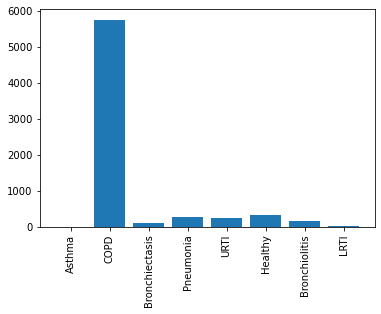

In [59]:
plotDataSet(dataSetPath , disease_labels)

In [60]:
def copy_targetConditions(targets = [], destination = 'target_conditions/',source = 'balanced_dataset/'):
    '''copy the files with names in target conditions list to the destination location'''
    files = os.listdir(source)
    if not os.path.exists(destination):
        os.makedirs(destination)
    for file in files:
        if (getFilenameInfo(file)[0] in targets):
            # print(getFilenameInfo(file)[0])
            shutil.copy(source + file , destination)
            

In [61]:
#copy_targetConditions(targets = target_conditions, destination = '../target_conditions/',source = '../balanced_dataset/')

{'COPD': 793, 'Healthy': 770, 'Pneumonia': 777, 'URTI': 782}

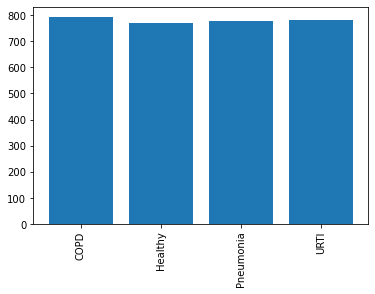

In [62]:
plotDataSet('../target_conditions/' , target_conditions)

In [63]:
from pathlib import Path
dataSetPathS = '../target_conditions/'
dataSetPath = Path('../target_conditions/')

files = os.listdir(dataSetPath)
# shuffle the data
random.shuffle(files)

labels = np.array([getFilenameInfo(file)[0] for file in files])
# print (str(labels[:10]) + 'files : ' + str(files[:10]))

# print(files)


In [64]:
print (labels[0])
print (files[0])



Pneumonia
Pneumonia_140_2b3_Tc_mc_LittC2SE_copy_12.wav


In [65]:
# dataset_path = "..\Datasets\Dataset1\Respiratory_Sound_Database\Respiratory_Sound_Database"
# csv_path = dataset_path + "\patient_diagnosis.csv"
# file_path = dataset_path + "\audio_and_txt_files"

In [66]:
# patient_data = pd.read_csv(csv_path,names=['Patient number', 'Diagnosis'])
# print (patient_data.head)

In [67]:


import IPython
def display_wav(list_id):
    patient_sounds = list(dataSetPath.glob(f'{files[list_id]}'))
    test_wav = librosa.core.load(patient_sounds[0], sr=16000)[0]

    fig, ax = plt.subplots(2, 1, figsize=(20,5))
    ax[0].plot(test_wav)
    ax[0].set_title(f"Full {files[list_id]} waveform")

    mel = librosa.feature.melspectrogram(test_wav, sr=16000, n_fft=512, hop_length=256, win_length=512, window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[1].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[1].set_title(f"Slice of {files[list_id]} mel spectrogram 512 fft")

C:\Users\iresh\AppData\Local\Temp\ipykernel_18040\2321289977.py:10: FutureWarning: Pass y=[ 0.33859253  0.33843994  0.33880615 ... -0.1210022  -0.1204834
 -0.12060547] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(test_wav, sr=16000, n_fft=512, hop_length=256, win_length=512, window='hann', n_mels=100)


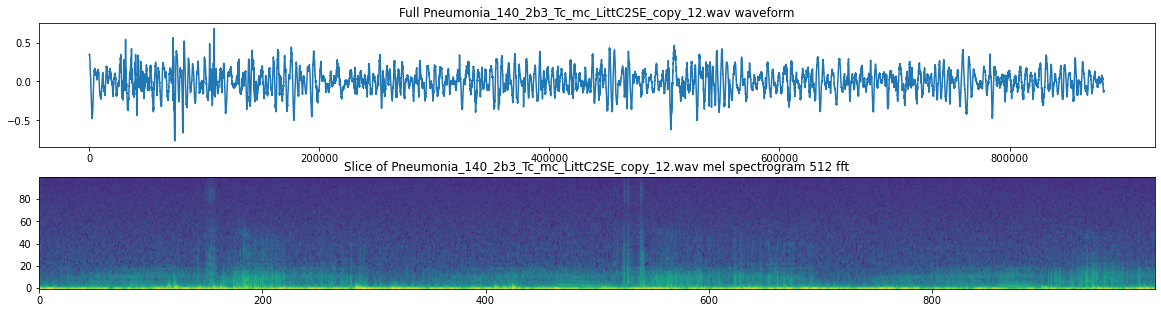

In [68]:
display_wav(0)

In [69]:
SAMPLE_WAV_SPEECH_PATH = dataSetPathS + files[0]
print (SAMPLE_WAV_SPEECH_PATH)
metadata = torchaudio.info(dataSetPathS + files[0])
print(metadata)    
# for i in range(0,len(files)):
#     waveform,sr = torchaudio.load(dataSetPathS + files[i])
#     # print(metadata) 
#     if (waveform.numel() !=882000):
#         print (waveform.numel())


waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
print (waveform.numel())

zerosT = torch.zeros([900000])
print (zerosT.numel())

zerosT[:waveform.numel()] = waveform
print (zerosT.numel())

small_zeros = torch.zeros([100000])
print (small_zeros.numel())
small_zeros = torch.narrow(waveform,1,0,10000)
print (small_zeros.numel())
     

../target_conditions/Pneumonia_140_2b3_Tc_mc_LittC2SE_copy_12.wav
AudioMetaData(sample_rate=16000, num_frames=882000, num_channels=1, bits_per_sample=16, encoding=PCM_S)
882000
900000
900000
100000
10000


In [70]:
le = LabelEncoder()
i_labels = le.fit_transform(labels)

# print(i_labels)
oneHotLabels = F.one_hot(torch.from_numpy(i_labels))
# print(oneHotLabels)
# print(oneHotLabels[:10])

features = np.array(files)


#split the data set

x_train,x_test,y_train,y_test = train_test_split(features,oneHotLabels,stratify=oneHotLabels,test_size=0.1,random_state = 42)
x_test,x_val,y_test,y_val = train_test_split(features,oneHotLabels,stratify=oneHotLabels,test_size=0.2,random_state = 42)


In [71]:
print(len(files))
print(len(labels))

3122
3122


In [72]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
# optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)


In [73]:
class AudioLSTM(nn.Module):

    def __init__(self, n_feature=5, out_feature=5, n_hidden=256, n_layers=2, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = n_feature

        self.lstm = nn.LSTM(self.n_feature, self.n_hidden, self.n_layers, dropout=self.drop_prob, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(n_hidden, out_feature)

    def forward(self, x, hidden):
        # x.shape (batch, seq_len, n_features)
        l_out, l_hidden = self.lstm(x, hidden)

        # out.shape (batch, seq_len, n_hidden*direction)
        out = self.dropout(l_out)

        # out.shape (batch, out_feature)
        out = self.fc(out[:, -1, :])

        # return the final output and the hidden state
        return out, l_hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        # hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
        #           weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        return hidden


In [74]:
train_loss = []
def train(model, epoch):
    model.train()
    tr_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        model.zero_grad()
        output, hidden_state = model(data.float(), model.init_hidden(hyperparameters["batch_size"]))
        
        loss = criterion(output, target)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))
        tr_loss.append(loss)
    train_loss.append(torch.mean(torch.FloatTensor(tr_loss)))

In [75]:
def test(model, epoch):
    model.eval()
    correct = 0
    y_pred, y_target = [], []
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        
        output, hidden_state = model(data.float(), model.init_hidden(hyperparameters["batch_size"]))
        
        pred = torch.max(output, dim=1).indices
        correct += pred.eq(target).cpu().sum().item()
        y_pred = y_pred + pred.tolist()
        y_target = y_target + target.tolist()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [76]:


class LungSoundDataSet(Dataset):
    def __init__(self,files,labels, file_path):
        self.files = files
        self.lables = labels
        self.file_path = file_path
      
    def __getitem__(self,index):
        path = self.file_path  + self.files[index]
        sound,sample_rate  = torchaudio.load(path)
        soundData = torch.mean(sound, dim=0, keepdim=True)
        #load returns a tensor with the sound data and the sampling frequency 
        outSound = []
        # print(self.files[index])
        tempData = torch.zeros([800000])
       
        #to zero pad shorter sound files
        if (sound.numel() > 800000):
            tempData = torch.narrow(sound ,1 ,0,800000)
        if (sound.numel() < 800000):
            tempData[:sound.numel()] = sound
        
            
        sound = tempData
        # print (sound.numel())
        downSamSound = sound         #to be chaged
        # print (downSamSound.numel())
      
        lable = 0
        condition = str(self.lables[index])
        # print(self.lables[index] )
        if condition== "Healthy":
            lable = 1
        if condition == "COPD":
            lable = 2
        if condition == "Pneumonia":
            lable = 3
        if condition == "URTI":
            lable = 4
        # print(lable)
        # mel_specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(downSamSound)  # (channel, n_mels, time)
    
        # WAVEFORM, SAMPLE_RATE = torchaudio.load(dataSetPath + '/audio_and_txt_files/'+ i +'.wav')
        mfcc_transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

        mel_specgram = mfcc_transform(downSamSound)
        #mel_specgram = torch.stft(downSamSound,n_fft = n_fft,hop_length=hop_length,return_complex =True)
        
        # mel_specgram_norm = (mel_specgram - mel_specgram.mean()) / mel_specgram.std()
        # mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate)(downSamSound)  # (channel, n_mfcc, time)
        
        # mfcc_norm = (mfcc - mfcc.mean()) / mfcc.std()
        # spectogram = torchaudio.transforms.Spectrogram(sample_rate=sample_rate)(soundData)
        # feature = torch.cat([mel_specgram, mfcc], axis=1)

        feature = mel_specgram
        # print(feature.shape)
        if (feature.shape != [1, 256, 1563]):
            # print(feature.shape)
            feature = feature.expand(1, 256, 1563)
            # print(feature.shape)
        x = feature[0].permute(1, 0)
       
        # print (feature.numel())
        return feature[0].permute(1, 0), lable

        
    def __len__(self):
        return len(self.files)

# train_set = LungSoundDataSet(files[:-100],labels[:-100],dataSetPathS)
# test_set = LungSoundDataSet(files[-100:],labels[-100:],dataSetPathS)
# # print (train_set.__getitem__(1))
# # print(files[1])
# print("Train set size: " + str(len(train_set)))
# print("Test set size: " + str(len(test_set)))

# kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

# train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, **kwargs)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, **kwargs)

In [77]:



a = torch.arange(4)
print (a.shape)
torch.reshape(a, (2, 2))
print (a.shape)
a = a.expand(1,4)
print (a.shape)
oo = torch.zeros([1,128])
a = oo
print (oo.shape)


torch.Size([4])
torch.Size([4])
torch.Size([1, 4])
torch.Size([1, 128])


In [78]:
hyperparameters = {"lr": 0.01, "weight_decay": 0.0001, "batch_size": 32, "in_feature": 256, "out_feature": 10}

# 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)
datasetSize = len(files)
print(datasetSize)
train_set = LungSoundDataSet(files[:int(datasetSize *0.7)],labels[:int(datasetSize *0.7)],dataSetPathS)
test_set = LungSoundDataSet(files[int(datasetSize *0.7):int(datasetSize *0.9)],labels[int(datasetSize *0.7):int(datasetSize *0.9)],dataSetPathS)
val_set = LungSoundDataSet(files[int(datasetSize *0.9):],labels[int(datasetSize *0.9):],dataSetPathS)

print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))
print("Val set size: " + str(len(val_set)))

kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}  # needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size=hyperparameters["batch_size"], shuffle=True, drop_last=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=hyperparameters["batch_size"], shuffle=True, drop_last=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=hyperparameters["batch_size"], shuffle=True, drop_last=True, **kwargs)

model = AudioLSTM(n_feature=hyperparameters["in_feature"], out_feature=hyperparameters["out_feature"])
model.to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()
clip = 5  # gradient clipping
n_epoch = 50
log_interval = 10
for epoch in range(1, n_epoch+1):
    # scheduler.step()
    train(model, epoch)
    test(model, epoch)

cuda
3122
Train set size: 2185
Test set size: 624
Val set size: 313
AudioLSTM(
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)
Train Epoch: 1 [0/2185 (0%)]	Loss: 2.302146
Train Epoch: 1 [320/2185 (15%)]	Loss: 1.027563
Train Epoch: 1 [640/2185 (29%)]	Loss: 1.807343
Train Epoch: 1 [960/2185 (44%)]	Loss: 1.218292
Train Epoch: 1 [1280/2185 (59%)]	Loss: 1.047901
Train Epoch: 1 [1600/2185 (74%)]	Loss: 0.820675
Train Epoch: 1 [1920/2185 (88%)]	Loss: 0.958120

Test set: Accuracy: 366/624 (59%)

Train Epoch: 2 [0/2185 (0%)]	Loss: 0.823444
Train Epoch: 2 [320/2185 (15%)]	Loss: 0.913999
Train Epoch: 2 [640/2185 (29%)]	Loss: 1.596510
Train Epoch: 2 [960/2185 (44%)]	Loss: 0.802415
Train Epoch: 2 [1280/2185 (59%)]	Loss: 0.995531
Train Epoch: 2 [1600/2185 (74%)]	Loss: 0.999217
Train Epoch: 2 [1920/2185 (88%)]	Loss: 0.881494

Test set: Accuracy: 374/624 (60%)

Train Epoch: 3 [

[tensor(1.2161), tensor(1.0813), tensor(0.9031), tensor(0.8268), tensor(1.1123), tensor(0.8494), tensor(0.8307), tensor(0.8360), tensor(0.7339), tensor(0.6175), tensor(0.6987), tensor(0.7393), tensor(0.5804), tensor(0.8415), tensor(1.0898), tensor(0.6866), tensor(0.8814), tensor(0.5235), tensor(0.6454), tensor(0.5982), tensor(0.6034), tensor(0.5298), tensor(0.5488), tensor(0.5461), tensor(0.6644), tensor(0.7063), tensor(0.6934), tensor(0.6626), tensor(0.7010), tensor(0.5385), tensor(0.5244), tensor(0.6060), tensor(0.7182), tensor(0.6598), tensor(0.7083), tensor(0.5620), tensor(0.6441), tensor(0.5799), tensor(0.5331), tensor(0.7061), tensor(0.6206), tensor(0.5980), tensor(0.5242), tensor(0.5426), tensor(1.0553), tensor(0.8041), tensor(0.8867), tensor(1.1958), tensor(0.9496), tensor(1.2379)]


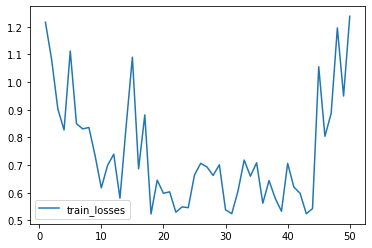

In [79]:

print((train_loss))
plt.plot([x for x in range (1,n_epoch+1)], train_loss)

plt.legend(['train_losses'])
plt.show()

[[ 0  0 71  9]
 [ 0 65  3  0]
 [ 0  0 70  0]
 [ 0  0 65  5]]


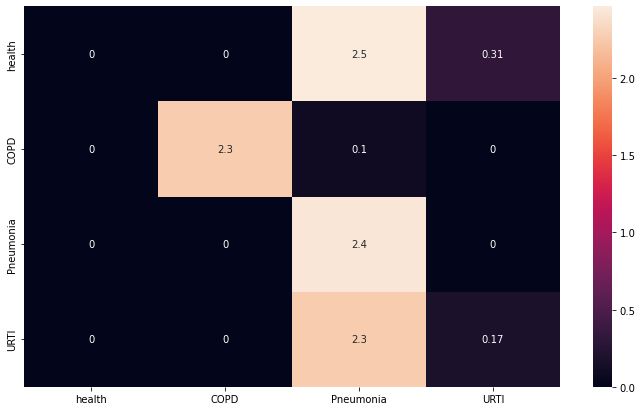

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output, hidden_state = model(inputs.float(), model.init_hidden(hyperparameters["batch_size"])) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('health', 'COPD',"Pneumonia","URTI")
# print(y_true)
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print (cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
